# E-commerce Recommendation System

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Business Understanding

### Project Overview
E-commerce platforms rely on personalized recommendations to improve user experience, increase engagement, and drive sales. Customers interact with products through various events such as **views, clicks, and add-to-cart actions**, but these interactions are often unstructured. The goal of this project is to **build a recommendation system that predicts item properties for "add to cart" events based on prior "view" events** while also detecting abnormal user behavior to enhance recommendation accuracy.

### Business Objectives
1. **Improve Personalization**
   - Predict which product properties influence a user's decision to add an item to the cart.
   - Help businesses tailor their recommendations based on implicit browsing behavior.

2. **Reduce Noise and Improve Efficiency**
   - Identify and remove **abnormal users** who introduce bias and noise into the dataset.
   - Ensure data quality for better recommendation performance.

3. **Enhance Customer Engagement and Sales**
   - Deliver relevant product recommendations, increasing conversion rates.
   - Improve user retention by optimizing the browsing experience.

### Problem Statement
- Customers interact with multiple products before making a purchase decision. However, the properties influencing these decisions (e.g., price, brand, availability) are not explicitly logged.
- **How can we infer product properties that contribute to an "add to cart" decision based on past "view" events?**
- Additionally, **how can we detect and filter out abnormal users who distort recommendation accuracy?**

### Data Understanding
The project relies on three key datasets:

#### 1. `events.csv` (User Interaction Data)
| Column       | Description |
|-------------|------------|
| `timestamp`  | Time when the interaction occurred. |
| `visitorid`  | Unique identifier for each user. |
| `event`      | Type of interaction (e.g., view, add to cart). |
| `itemid`     | Unique identifier for each product. |
| `transactionid` | Identifies transactions (for purchases). |

#### 2. `item_properties.csv` (Product Metadata)
| Column       | Description |
|-------------|------------|
| `timestamp`  | Time when the property was recorded. |
| `itemid`     | Product identifier. |
| `property`   | Feature of the product (e.g., category, availability). |
| `value`      | Corresponding value of the property. |

#### 3. `category_tree.csv` (Product Category Data)
| Column       | Description |
|-------------|------------|
| `categoryid`  | Child category identifier |
| `parentid`     | Parent category identifier. |

### Project Scope
- **Task 1:** Develop an algorithm to predict item properties for "add to cart" events based on "view" events.
- **Task 2:** Detect abnormal users who generate noise and remove them to improve recommendation accuracy.

By addressing these tasks, the project will deliver a robust recommendation system that enhances **e-commerce personalization** and **business intelligence insights** while ensuring **clean and reliable data**. 🚀

### Hypothesis Testing
- **Null Hypothesis(Ho):**
- **Alternate Hypothesis(Ha):**

### Analytical Questions
1. How do we identify product properties that influence an "add to cart" decision?
2. What factors contribute to the decision to add an item to the cart?
3. How can we detect and filter out abnormal users who distort recommendation accuracy?
4. What are the potential impacts of this recommendation system on the e-commerce business?
5. How can we measure the success of this recommendation system and improve it over time?
6. Does visit time have influence on an "add to cart" decision?
7. What is the view to "add to cart" conversion rate?



#### Import all necessary libraries

In [48]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Statistical Libraries
from scipy import stats

# Feature Engineering Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Machine Learning Libraries
# from lightgbm import LGBMClassifier

# Metrics Libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Utils
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

print("Successfully imported all libraries...")

Successfully imported all libraries...


#### Data Understanding

In [3]:
# Load datasets
events_df = pd.read_csv('/content/drive/MyDrive/data/events.csv')
item_properties1_df = pd.read_csv('/content/drive/MyDrive/data/item_properties_part1.1.csv')
item_properties2_df = pd.read_csv('/content/drive/MyDrive/data/item_properties_part2.csv', dtype={"property":"object"})
category_tree_df = pd.read_csv('/content/drive/MyDrive/data/category_tree.csv')



In [4]:
# Load the events_df
events_df

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [5]:
# Load the category_tree_df
category_tree_df

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [6]:
# Load the item_properties1_df
item_properties1_df

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [7]:
# Load the item_properties2_df
item_properties2_df

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062
...,...,...,...,...
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062


#### Concatenate the item properties dataframes

In [8]:
item_properties_df = pd.concat([item_properties1_df,item_properties2_df],ignore_index=True)

# Display the first few rows of the concatenated dataframe

item_properties_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [9]:
# check the shape of the new items_properties_df

item_properties_df.shape

(20275902, 4)

#### Create New Features from Property column of the item_properties

In [10]:
# initialize the categoryid and available columns
item_properties_df["categoryid"] = np.nan
item_properties_df["available"] = np.nan

# Assign values to the new column based on the 'property' column
item_properties_df.loc[item_properties_df["property"] == "categoryid","categoryid"] = item_properties_df["value"]
item_properties_df.loc[item_properties_df["property"] == "available","available"] = item_properties_df["value"]

In [11]:

# Move all the already existing numerical category ids into categoryid column
item_properties_df.loc[item_properties_df["property"].str.isnumeric(), "categoryid"] = item_properties_df["property"]

In [12]:
# create new column called description column
item_properties_df["description"] = item_properties_df.apply(
    lambda row: row["value"] if row["property"] not in ["categoryid","available"] else np.nan, axis=1 )


In [13]:
# drop unnecessary property and value columns
item_properties_df.drop(["property", "value"], axis=1, inplace=True)

In [14]:
# confirm changes
item_properties_df

,timestamp,itemid,categoryid,available,description
0,1435460400000,460429,1338,NaN,NaN
1,1441508400000,206783,888,NaN,1116713 960601 n277.200
2,1439089200000,395014,400,NaN,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,NaN,n15360.000
4,1431831600000,156781,917,NaN,828513
...,...,...,...,...,...
20275897,1433646000000,236931,929,NaN,n12.000
20275898,1440903600000,455746,6,NaN,150169 639134
20275899,1439694000000,347565,686,NaN,610834
20275900,1433646000000,287231,867,NaN,769062


In [15]:
# Get info about the item_properties_df

item_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   timestamp    int64 
 1   itemid       int64 
 2   categoryid   object
 3   available    object
 4   description  object
dtypes: int64(2), object(3)
memory usage: 773.5+ MB


In [16]:
# check for null values
item_properties_df.isna().sum()

,0
timestamp,0
itemid,0
categoryid,1503639
available,18772263
description,2291853


In [17]:
# Look at the events_df
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [18]:
# check for null values
events_df.isna().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733644


In [19]:
item_properties_df.duplicated().sum()

0

#### Merging Datasets
-  I will first convert the timestamp to datetime so I will base merge on it
- The merge strategy to be used for merging the events_df and the item_properties is the inner join.
- I shall consider the timestamp and the itemid as the two unique columns to base my joins on.
- I will finally merge the item_event dataframe to category_tree based on the categoryid to form the final_df

In [20]:
# Convert timestamp in item properties to datetime
item_properties_df["timestamp"] = pd.to_datetime(item_properties_df["timestamp"])

# Convert timestamp in events to
events_df["timestamp"] = pd.to_datetime(events_df["timestamp"])


item_properties_df["timestamp"] = item_properties_df["timestamp"].dt.floor("s")
events_df["timestamp"] = events_df["timestamp"].dt.floor("s")


In [21]:
# confirm changes
item_properties_df["timestamp"].head()

,timestamp
0,1970-01-01 00:23:55
1,1970-01-01 00:24:01
2,1970-01-01 00:23:59
3,1970-01-01 00:23:51
4,1970-01-01 00:23:51


In [22]:
# Rename timestamp columns to datetime column
item_properties_df = item_properties_df.rename(columns = {"timestamp":"datetime"})
events_df = events_df.rename(columns={"timestamp": "datetime"})

In [23]:
# Convert datetime dtype to s
item_properties_df["datetime"] = item_properties_df["datetime"].astype("datetime64[s]")
events_df["datetime"] = events_df["datetime"].astype("datetime64[s]")


In [24]:
# Inner merge using datetime and itemid
event_item_df = events_df.merge(item_properties_df, on=["datetime","itemid"], how="inner", indicator=True)

In [25]:
# count the indicator types
event_item_df["_merge"].value_counts()

,count
_merge,
both,14701714
left_only,0
right_only,0


In [26]:
event_item_df.head()

,datetime,visitorid,event,itemid,transactionid,categoryid,available,description,_merge
0,1970-01-01 00:23:53,257597,view,355908,NaN,1036,NaN,726612,both
1,1970-01-01 00:23:53,257597,view,355908,NaN,364,NaN,610075,both
2,1970-01-01 00:23:53,257597,view,355908,NaN,400,NaN,n600.000 424566,both
3,1970-01-01 00:23:53,257597,view,355908,NaN,400,NaN,n600.000 424566,both
4,1970-01-01 00:23:53,257597,view,355908,NaN,1066,NaN,n1020.000 424566,both


In [27]:
# view last five rows
event_item_df.tail()

,datetime,visitorid,event,itemid,transactionid,categoryid,available,description,_merge
14701709,1970-01-01 00:23:58,289041,view,156947,NaN,256,NaN,NaN,both
14701710,1970-01-01 00:23:58,1251746,view,78144,NaN,790,NaN,n14760.000,both
14701711,1970-01-01 00:23:58,1251746,view,78144,NaN,NaN,1,NaN,both
14701712,1970-01-01 00:23:58,1184451,view,283392,NaN,790,NaN,n17280.000,both
14701713,1970-01-01 00:23:58,1184451,view,283392,NaN,888,NaN,576405 448577 903215 707081 616719 n65004.000 ...,both


In [28]:
event_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14701714 entries, 0 to 14701713
Data columns (total 9 columns):
 #   Column         Dtype        
---  ------         -----        
 0   datetime       datetime64[s]
 1   visitorid      int64        
 2   event          object       
 3   itemid         int64        
 4   transactionid  float64      
 5   categoryid     object       
 6   available      object       
 7   description    object       
 8   _merge         category     
dtypes: category(1), datetime64[s](1), float64(1), int64(2), object(4)
memory usage: 911.3+ MB


In [29]:
# Convert the categoryid and available to int datatype

event_item_df["categoryid"] = event_item_df["categoryid"].astype("Int64")
event_item_df["available"] = event_item_df["available"].astype("Int64")


In [30]:
event_item_df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,14701714,1970-01-01 00:23:55,1970-01-01 00:23:51,1970-01-01 00:23:53,1970-01-01 00:23:55,1970-01-01 00:23:57,1970-01-01 00:24:02,NaN
visitorid,14701714.0,700197.407164,0.0,348688.0,699274.0,1052249.0,1407579.0,405834.874983
itemid,14701714.0,235302.130921,3.0,118138.0,237422.0,351551.0,466864.0,134457.278198
transactionid,139150.0,8779.563047,0.0,4291.0,8728.0,13271.0,17671.0,5139.658765
categoryid,12834008.0,648.642611,0.0,400.0,790.0,888.0,1697.0,309.776213
available,1867706.0,0.780898,0.0,1.0,1.0,1.0,1.0,0.413638


In [31]:
# Merge item_event_df to category_id
final_df = event_item_df.merge(category_tree_df, how="left", on="categoryid")


In [33]:
# drop the merge column
final_df.drop("_merge", axis=1, inplace=True)

In [32]:
# save final_df to cvs
final_df.to_csv("final_df.csv", index=False)

#### Exploratory Data Analysis

In [34]:
# check the shape of the final_df
final_df.shape

(14701714, 9)

In [35]:
# View first five rows
final_df.head()

,datetime,visitorid,event,itemid,transactionid,categoryid,available,description,parentid
0,1970-01-01 00:23:53,257597,view,355908,NaN,1036,<NA>,726612,1420.0
1,1970-01-01 00:23:53,257597,view,355908,NaN,364,<NA>,610075,711.0
2,1970-01-01 00:23:53,257597,view,355908,NaN,400,<NA>,n600.000 424566,110.0
3,1970-01-01 00:23:53,257597,view,355908,NaN,400,<NA>,n600.000 424566,110.0
4,1970-01-01 00:23:53,257597,view,355908,NaN,1066,<NA>,n1020.000 424566,293.0


In [36]:
# check the info about final_df
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14701714 entries, 0 to 14701713
Data columns (total 9 columns):
 #   Column         Dtype        
---  ------         -----        
 0   datetime       datetime64[s]
 1   visitorid      int64        
 2   event          object       
 3   itemid         int64        
 4   transactionid  float64      
 5   categoryid     Int64        
 6   available      Int64        
 7   description    object       
 8   parentid       float64      
dtypes: Int64(2), datetime64[s](1), float64(2), int64(2), object(2)
memory usage: 1.0+ GB


In [37]:
# perform summary descriptive analysis on the final_df
final_df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,14701714,1970-01-01 00:23:55,1970-01-01 00:23:51,1970-01-01 00:23:53,1970-01-01 00:23:55,1970-01-01 00:23:57,1970-01-01 00:24:02,NaN
visitorid,14701714.0,700197.407164,0.0,348688.0,699274.0,1052249.0,1407579.0,405834.874983
itemid,14701714.0,235302.130921,3.0,118138.0,237422.0,351551.0,466864.0,134457.278198
transactionid,139150.0,8779.563047,0.0,4291.0,8728.0,13271.0,17671.0,5139.658765
categoryid,12834008.0,648.642611,0.0,400.0,790.0,888.0,1697.0,309.776213
available,1867706.0,0.780898,0.0,1.0,1.0,1.0,1.0,0.413638
parentid,12646169.0,957.247399,8.0,648.0,897.0,1492.0,1698.0,480.562854


In [38]:
# check for duplicates
final_df.duplicated().sum()

4832278

In [39]:
# drop duplicates
final_df.drop_duplicates(inplace=True)

In [40]:
# confirm changes
final_df.duplicated().sum()

0

In [41]:
# shape of final_df after dropping duplicates
final_df.shape

(9869436, 9)

In [42]:
# check for null values
final_df.isna().sum()

,0
datetime,0
visitorid,0
event,0
itemid,0
transactionid,9752953
categoryid,1081901
available,8787535
description,1406017
parentid,1215218


#### Handling Null Values

In [43]:
# calculate percentage of null values
(final_df.isna().sum()/final_df.shape[0])*100

,0
datetime,0.000000
visitorid,0.000000
event,0.000000
itemid,0.000000
transactionid,98.819760
categoryid,10.962136
available,89.037864
description,14.246174
parentid,12.312943


In [44]:
# check for unique values in columns
for col in final_df.columns:
  print(f"{col} has {final_df[col].nunique()} unique values")

datetime has 12 unique values
visitorid has 1095680 unique values
event has 3 unique values
itemid has 166305 unique values
transactionid has 16596 unique values
categoryid has 1480 unique values
available has 2 unique values
description has 439442 unique values
parentid has 350 unique values


In [45]:
# print unique values
for col in final_df.columns:
  print(f"{col} has {final_df[col].unique()}")

datetime has <DatetimeArray>
['1970-01-01 00:23:53', '1970-01-01 00:23:54', '1970-01-01 00:23:55',
 '1970-01-01 00:23:58', '1970-01-01 00:23:59', '1970-01-01 00:24:00',
 '1970-01-01 00:24:01', '1970-01-01 00:24:02', '1970-01-01 00:23:51',
 '1970-01-01 00:23:52', '1970-01-01 00:23:56', '1970-01-01 00:23:57']
Length: 12, dtype: datetime64[s]
visitorid has [ 257597  992329  483717 ... 1392454  226214 1184451]
event has ['view' 'addtocart' 'transaction']
itemid has [355908 248676 253185 ...    613  52086 177353]
transactionid has [   nan  4000. 11117. ...  4385. 13872. 17579.]
categoryid has <IntegerArray>
[1036,  364,  400, 1066,  566,  899,  790,  698,  888, <NA>,
 ...
 1225, 1310, 1520,  190, 1484,  733, 1506, 1425,  474, 1281]
Length: 1481, dtype: Int64
available has <IntegerArray>
[<NA>, 1, 0]
Length: 3, dtype: Int64
description has ['726612' '610075' 'n600.000 424566' ... '216437' '1052172 462726'
 '934918']
parentid has [1420.  711.  110.  293.   nan 1492. 1251.  866.  602.  605. 16

#### Summary of Missing Values
- transactionid (98.82% missing) → Mostly missing, likely because many events are not purchases.
- available (89.04% missing) → Might be missing due to data collection issues or products being discontinued.
- categoryid (10.96% missing) → A moderate percentage is missing, likely due to unmapped items.
- description (14.25% missing) → Product descriptions may be optional or unavailable.
- parentid (12.31% missing) → Could be due to items not having a parent category.

#### Strategies for handling of missing values
- We will drop the transactionid column. If a column has over 90% missing values, it likely adds little value.
Since transactionid is missing in 98.82% of cases, it may not be useful for analysis.
- Although the available column has a great percentage of missing values, we will keep it and fill the Null Values with 0.
- The categoryid, parentid will be filled with the mode values of the columns during the data processing phase
- The description column too will be filled with contextual filling by using the itemid and categoryid



In [46]:
# drop the transactionid column
final_df.drop("transactionid", axis=1, inplace=True)

#### Univariate Analysis

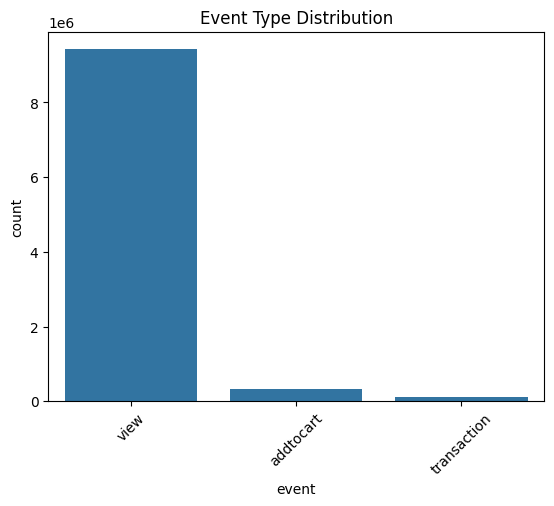

In [49]:
# countplot of event
sns.countplot(x=final_df["event"])
plt.title("Event Type Distribution")
plt.xticks(rotation=45)  # Rotate for readability
plt.show()


There is an uneven distribution of events. A very few events ended up in transaction, a few in add to cart and the majority of the events being the view event.

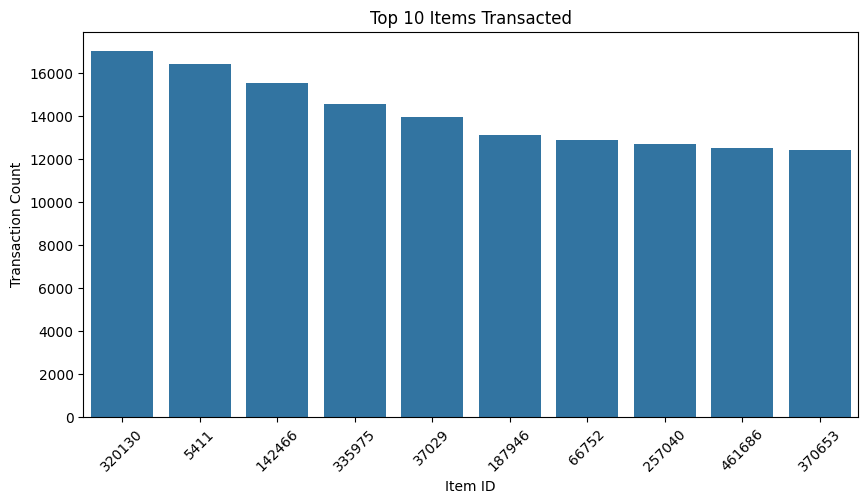

In [52]:
# Get the top 10 items
top_items = event_item_df["itemid"].value_counts().nlargest(10)
top_items = top_items.sort_values(ascending=False)  # order ids in descending order

plt.figure(figsize=(10, 5))
sns.barplot(x=top_items.index.astype(str), y=top_items.values)  # Convert IDs to string
plt.title("Top 10 Items Transacted")
plt.xlabel("Item ID")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()


#### Answering Analytical Questions

#### Hypothesis Testing

## Data Preparation

## Modeling and Evaluation

## Deployment

## Conclusion